Dataset organized into train, validation, and test splits.
Found 1432 images belonging to 5 classes.
Found 478 images belonging to 5 classes.
Found 480 images belonging to 5 classes.


c:\python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 273s 6s/step - accuracy: 0.6010 - loss: 0.9585 - val_accuracy: 0.7992 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.8441 - loss: 0.4229 - val_accuracy: 0.8515 - val_loss: 0.4322 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 251s 6s/step - accuracy: 0.8676 - loss: 0.3886 - val_accuracy: 0.8536 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 321s 7s/step - accuracy: 0.8745 - loss: 0.3446 - val_accuracy: 0.8598 - val_loss: 0.4492 - learning_rate: 0.0010
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.8985 - loss: 0.2842 - val_accuracy: 0.8745 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9385 - loss: 0.1982
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
45/45 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.9380 - loss: 0.1991 - val_accura

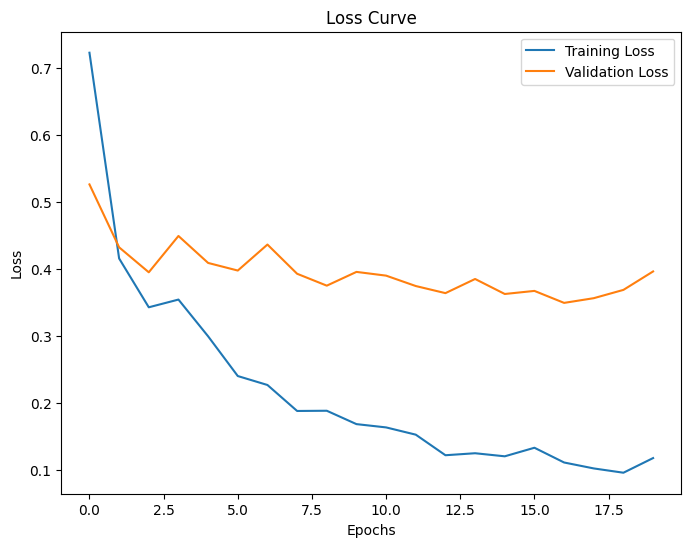

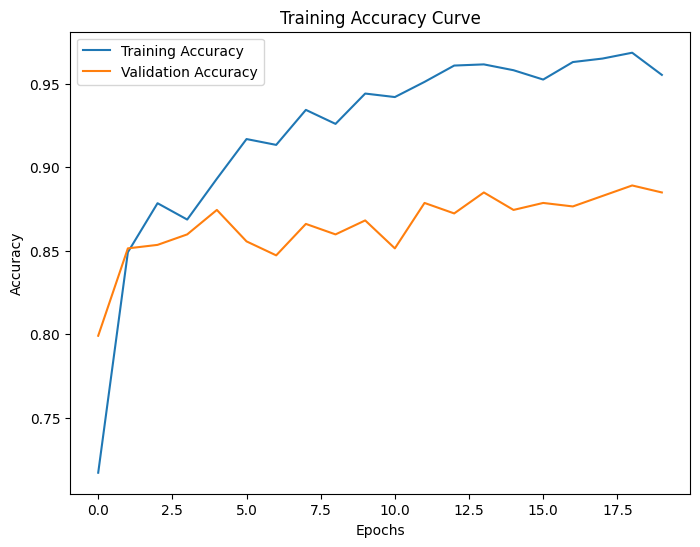

15/15 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9140 - loss: 0.3096
Test Accuracy: 89.79%
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.94      0.96        81
       glass       0.91      0.86      0.88       101
       metal       0.85      0.91      0.88        82
       paper       0.88      0.98      0.93       119
     plastic       0.88      0.78      0.83        97

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480



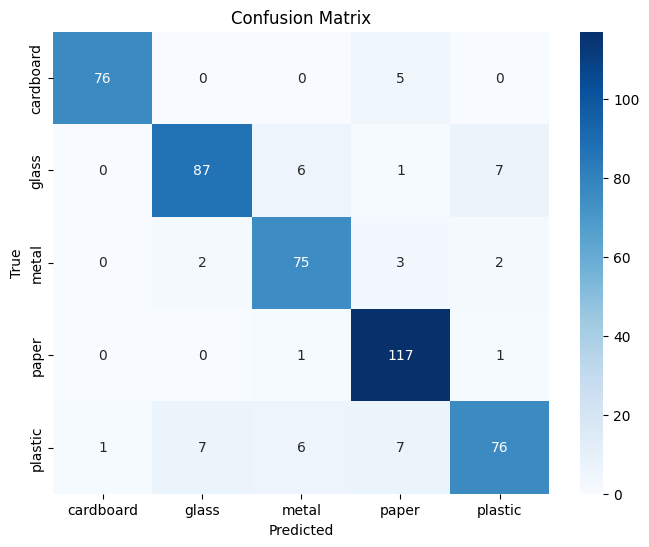

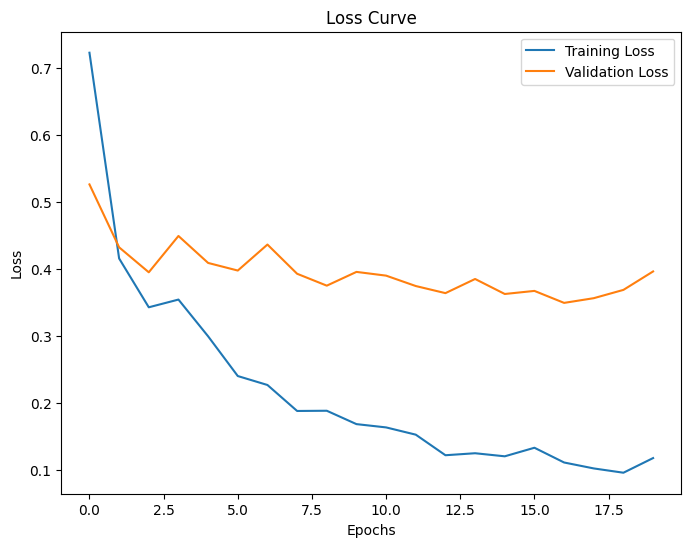

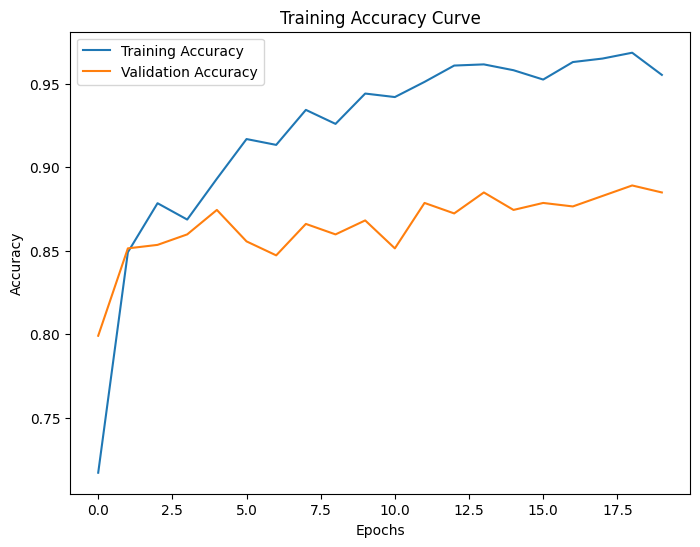

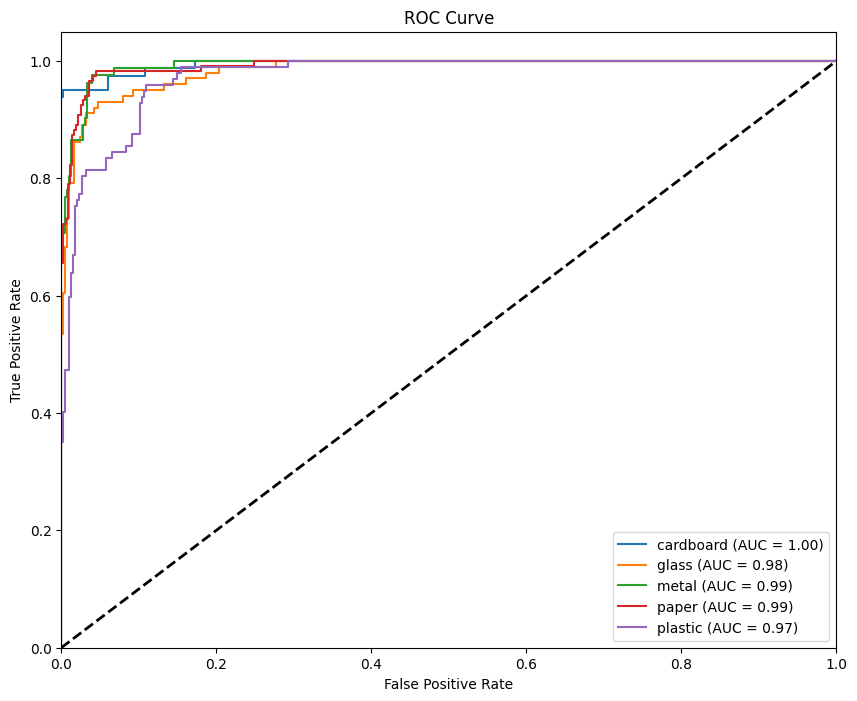

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

original_data_dir = "C:\\Users\\Admin\\Desktop\\Garbage classification"
base_dir = "processed_dataset"

# Updated classes in the dataset (removed "trash")
classes = ["cardboard", "glass", "metal", "paper", "plastic"]


os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

for cls in classes:
    cls_dir = os.path.join(original_data_dir, cls)
    if os.path.exists(cls_dir):
        images = os.listdir(cls_dir)
        train_imgs, temp_imgs = train_test_split(images, test_size=0.4, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))
        for img in test_imgs:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))
    else:
        print(f"Directory for class '{cls}' not found!")

print("Dataset organized into train, validation, and test splits.")

image_size = (224, 224)
batch_size = 32

datagen_with_aug = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen_with_aug.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

val_gen = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

test_gen = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# === Build and Train Xception Model ===
def build_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax', dtype='float32')(x)  # Force float32 output for stability

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers for initial training
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = build_xception_model()

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)
# === Visualize Training Process ===

# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Visualize Training Process ===

# Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training Accuracy Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# === ROC Curve and AUC ===
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [3]:
# Save the entire model
model.save("model_path.h5")

# To load it later
from tensorflow.keras.models import load_model
loaded_model = load_model("model_path.h5")


In [4]:
# Save the model in the new Keras format
model.save("my_model.keras")
